# R: Testy statystyczne i wizualizacja
# Zbiór danych z 1.000.000 obserwacji
---
## 1. Biblioteki i edycja danych
### 1.1 Biblioteki

In [1]:
library(dplyr)
library(ggplot2)
library(FSA)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'FSA' was built under R version 3.6.3"## FSA v0.8.30. See citation('FSA') if used in publication.
## Run fishR() for related website and fishR('IFAR') for related book.


### 1.2 Wczytanie i edycja danych (czasów wykonywania dla zbioru milionowego)

In [2]:
csv_data <- read.csv("LMM_times_BIG_1e6_gam.csv",
                     col.names = c("statsmodel_formula", "statsmodel_matrix", "lme4", "nlme", "mgcv"))

head(csv_data)

statsmodel_formula,statsmodel_matrix,lme4,nlme,mgcv
1.5731,1.5631,9.2887,11.5224,3.6673
1.6571,1.8300,10.3971,11.7103,3.4722
1.9209,1.7130,9.3047,11.7643,3.7670
1.7550,1.5611,9.6025,11.1846,3.8170
1.9279,1.4991,9.0728,10.0722,4.0760
1.8369,1.4582,10.3841,12.2170,3.9451


In [3]:
csv_data_2 <- stack(csv_data) %>%
    rename(Czas_wykonania = values, Biblioteka = ind) %>%
        mutate(Jezyk = ifelse(Biblioteka %in% c("statsmodel_formula", "statsmodel_matrix"), "Python", "R"))

head(csv_data_2)

Czas_wykonania,Biblioteka,Jezyk
1.5731,statsmodel_formula,Python
1.6571,statsmodel_formula,Python
1.9209,statsmodel_formula,Python
1.7550,statsmodel_formula,Python
1.9279,statsmodel_formula,Python
1.8369,statsmodel_formula,Python


## 2. Wizualizacja
### 2.1 Zestawienie czasów wykonywania funkcji bibliotek języków Python i R

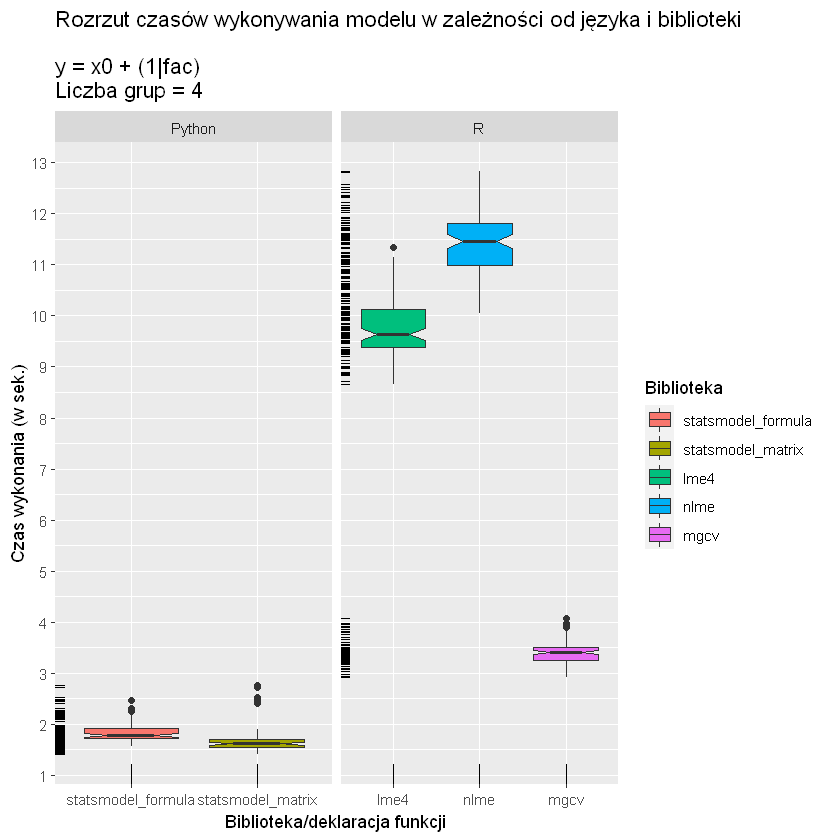

In [4]:
csv_data_2 %>%
      ggplot(aes(x=Biblioteka, y=Czas_wykonania, fill=Biblioteka)) +
      ggtitle("Rozrzut czasów wykonywania modelu w zależności od języka i biblioteki\n\ny = x0 + (1|fac)\nLiczba grup = 4") +
      xlab("Biblioteka/deklaracja funkcji") +
      ylab("Czas wykonania (w sek.)") +
      geom_boxplot(notch=TRUE) + geom_rug() +
      facet_wrap(~Jezyk, scales="free_x") +
      scale_y_continuous(breaks=seq(0, 13, 1))

### 2.2 Zestawienie czasów wykonywania deklaracji funkcji biblioteki "statsmodel" w języku Python

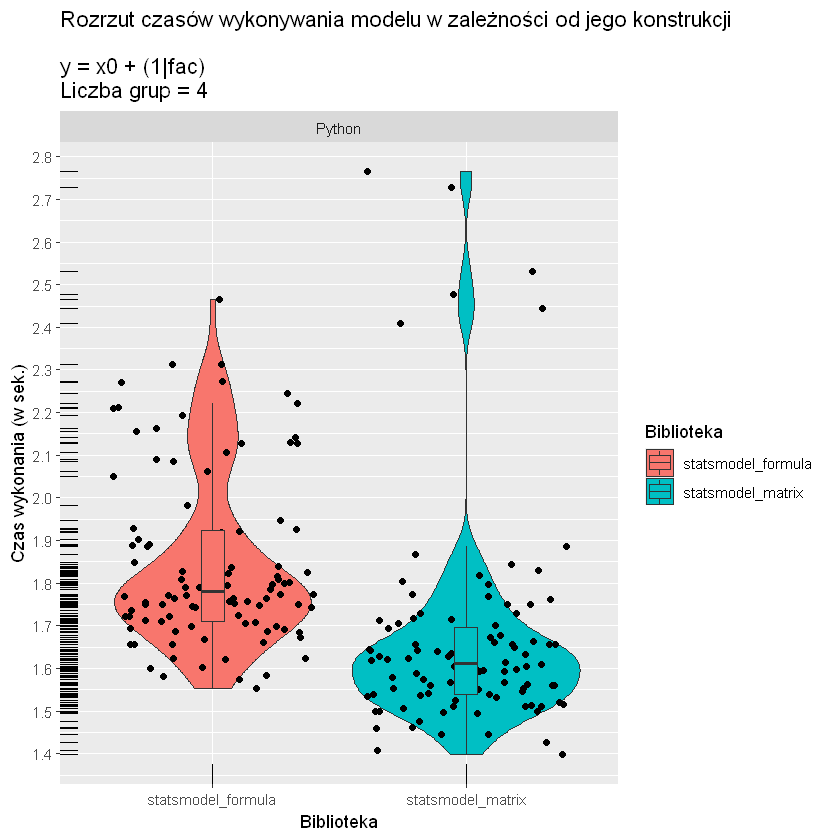

In [5]:
csv_data_2 %>%
    filter(Biblioteka %in% c("statsmodel_formula", "statsmodel_matrix")) %>%
        ggplot(aes(x=Biblioteka, y=Czas_wykonania, fill=Biblioteka)) +
        scale_y_continuous(breaks=seq(0, 3, 0.1)) +
        ggtitle("Rozrzut czasów wykonywania modelu w zależności od jego konstrukcji\n\ny = x0 + (1|fac)\nLiczba grup = 4") +
        ylab("Czas wykonania (w sek.)") +
        geom_violin(aes(fill = Biblioteka)) + geom_jitter() + geom_boxplot(width = .09, outlier.colour = NA) + geom_rug() +
        facet_wrap(~Jezyk)

### 2.3 Zestawienie czasów wykonywania funkcji z bibliotek "lme4", "nlme" i "bam" w języku R

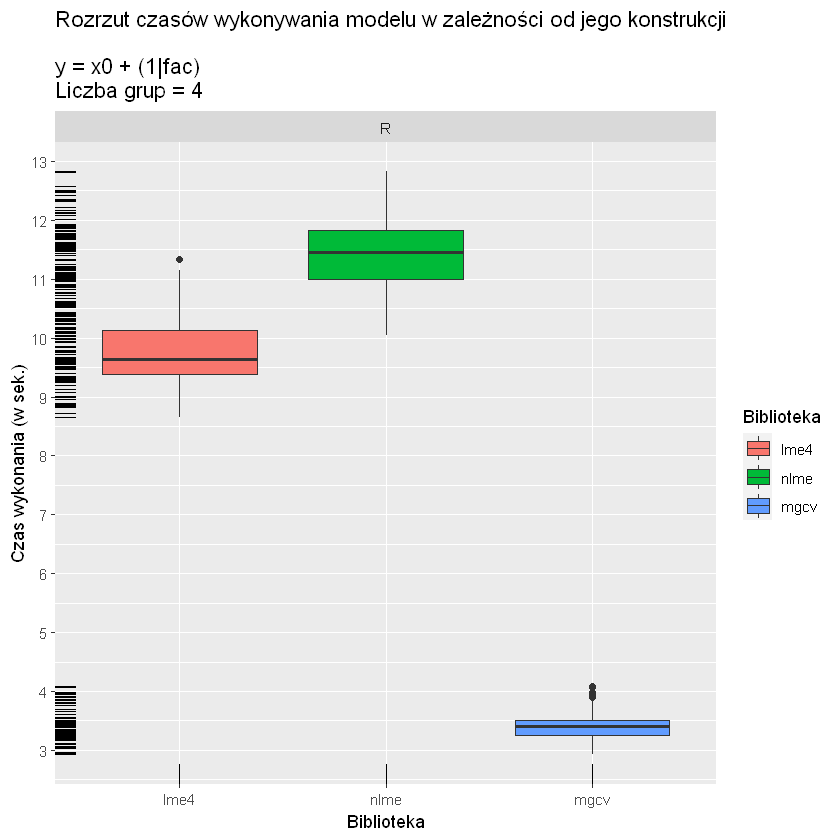

In [6]:
csv_data_2 %>%
    filter(Biblioteka %in% c("lme4", "nlme", "mgcv")) %>%
        ggplot(aes(x=Biblioteka, y=Czas_wykonania, fill=Biblioteka)) +
        scale_y_continuous(breaks=seq(0, 13, 1)) +
        ggtitle("Rozrzut czasów wykonywania modelu w zależności od jego konstrukcji\n\ny = x0 + (1|fac)\nLiczba grup = 4") +
        ylab("Czas wykonania (w sek.)") +
        geom_boxplot() + geom_rug() +
        facet_wrap(~Jezyk)

### 2.4 Zestawienie czasów wykonywania funkcji z bibliotek "lme4", "nlme" w języku R

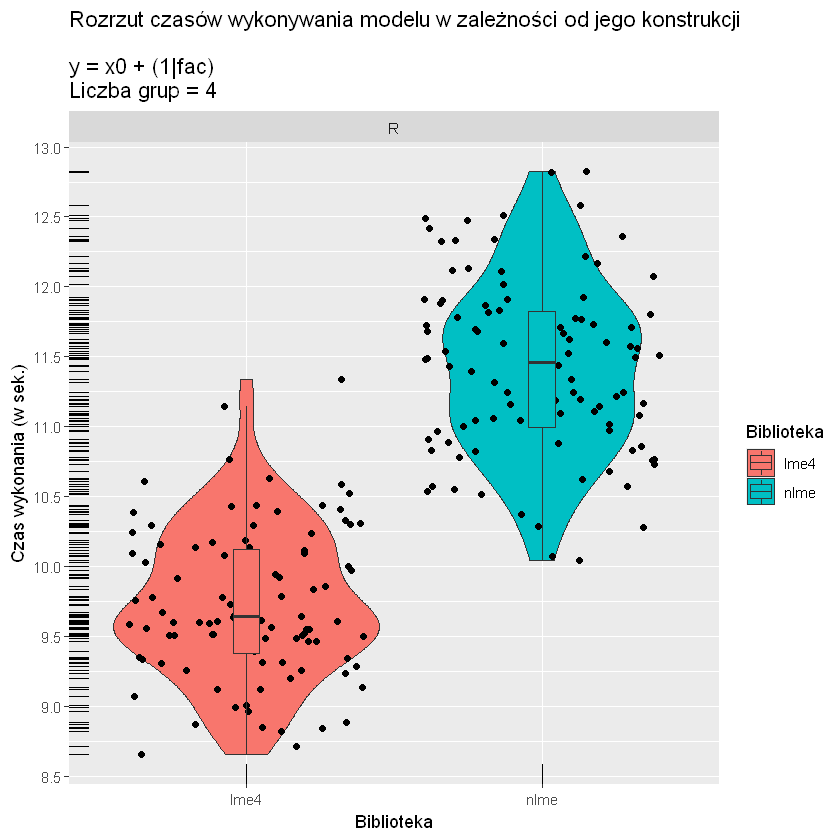

In [7]:
csv_data_2 %>%
    filter(Biblioteka %in% c("lme4", "nlme")) %>%
        ggplot(aes(x=Biblioteka, y=Czas_wykonania, fill=Biblioteka)) +
        scale_y_continuous(breaks=seq(0, 13, 0.5)) +
        ggtitle("Rozrzut czasów wykonywania modelu w zależności od jego konstrukcji\n\ny = x0 + (1|fac)\nLiczba grup = 4") +
        ylab("Czas wykonania (w sek.)") +
        geom_violin(aes(fill = Biblioteka)) + geom_jitter() + geom_boxplot(width = .09, outlier.colour = NA) + geom_rug() +
        facet_wrap(~Jezyk)

## 3. Testy statystyczne

### 3.1 Sprawdzenie różnic w średnich czasów wykonywania biblioteki statsmodel "formula" i "matrix" (Python)
#### 3.1.1 Sprawdzenie normalności rozkładów
##### > H0: Czasy wykonywania funkcji z bibliotek mają rozkład normalny
##### > HA: Czasy wykonywania funkcji z bibliotek nie mają rozkładu normalnego

In [8]:
for(i in c("statsmodel_formula", "statsmodel_matrix")) {
    print(shapiro.test(csv_data_2$Czas_wykonania[csv_data_2$Biblioteka == i]))
}


	Shapiro-Wilk normality test

data:  csv_data_2$Czas_wykonania[csv_data_2$Biblioteka == i]
W = 0.88909, p-value = 4.492e-07


	Shapiro-Wilk normality test

data:  csv_data_2$Czas_wykonania[csv_data_2$Biblioteka == i]
W = 0.65022, p-value = 4.304e-14



##### Wniosek: Brak normalności rozkładów

#### 3.1.2 Test Wilcoxona (nieparametryczny)
##### > H0: Średnie czasy wykonywania funkcji z użyciem metod "formula" i "matrix" nie różnią się
##### > HA: Średni czas wykonywania funkcji metody "formula" jest większy niż "matrix"

In [9]:
wilcox.test(csv_data$statsmodel_formula, csv_data$statsmodel_matrix, alternative="greater")


	Wilcoxon rank sum test with continuity correction

data:  csv_data$statsmodel_formula and csv_data$statsmodel_matrix
W = 8265.5, p-value = 7.45e-16
alternative hypothesis: true location shift is greater than 0


###### Wniosek Średni czas wykonywania funkcji metody "formula" jest większy niż "matrix"

### 3.2 Sprawdzenie różnic w średnich czasów wykonywania wszystkich bibliotek
#### 3.2.1 Nieparametryczna ANOVA
##### > H0: Średnie czasy wykonywania funkcji nie różnią się.
##### > HA: Średnie czasy wykonywania różnią się dla przynajmniej jednej pary funkcji.

In [10]:
kruskal.test(csv_data)


	Kruskal-Wallis rank sum test

data:  csv_data
Kruskal-Wallis chi-squared = 463.39, df = 4, p-value < 2.2e-16


##### > Wniosek: Średnie czasy wykonywania różnią się dla przynajmniej jednej pary funkcji.

##### 3.2.2 Test Dunneta - do sprawdzenia istotności różnic w grupach (funkcjach)

In [11]:
dun <- dunnTest(data=csv_data_2, Czas_wykonania~Biblioteka, kw=TRUE)

dun$res[order(abs(dun$res[2]), decreasing = TRUE),]

,Comparison,Z,P.unadj,P.adj
9,nlme - statsmodel_matrix,18.627655,1.917439e-77,1.917439e-76
6,nlme - statsmodel_formula,15.431322,1.007841e-53,9.070572e-53
7,lme4 - statsmodel_matrix,13.933240,3.978875e-44,3.183100e-43
4,lme4 - statsmodel_formula,10.736907,6.829380e-27,4.780566e-26
3,mgcv - nlme,-9.688348,3.379508e-22,2.027705e-21
8,mgcv - statsmodel_matrix,8.939307,3.916189e-19,1.958095e-18
5,mgcv - statsmodel_formula,5.742974,9.302787e-09,3.721115e-08
1,lme4 - mgcv,4.993933,5.916186e-07,1.774856e-06
2,lme4 - nlme,-4.694415,2.673712e-06,5.347423e-06
10,statsmodel_formula - statsmodel_matrix,3.196333,1.391866e-03,1.391866e-03


##### > Wniosek: We wszystkich parach średnie czasy wykonywania różnią się. Największa różnica występuje między bibliotekami "nlme" i "statsmodel_matrix", natomiast najmniejsza - "statsmodel_formula" i "statsmodel_matrix" w języku Python.